In [6]:
# import libraries
# all imports should be in OtodomScraper class without pandas lib
from selenium import webdriver
from bs4 import BeautifulSoup as bs
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import pandas as pd
import numpy as np

In [7]:
# create options object for chromium webdriver
options = webdriver.ChromeOptions()

In [8]:
# setup path for brave binary (executable file)
options.binary_location = "C:\\Program Files (x86)\\BraveSoftware\\Brave-Browser\\Application\\brave.exe"
options.add_argument("--headless")
# downloaded chromium driver binaries and place it in project directory
chrome_driver_binary = "chromedriver.exe"

In [9]:
# attributes to collect
offer_id = []
offer_description = []

In [10]:
# helpers
# starting page
current_page = 1
# max pages
page_number = 100
# doubled offers number
doubled_offers = 0
# offer dictionary for DataFrame purpose
offer_row = {}

In [ ]:
# Chrome - controls browser
driver = webdriver.Chrome(chrome_driver_binary, options=options)
# choose which site you want to visit
driver.get("https://www.otodom.pl/sprzedaz/mieszkanie/wroclaw/?search%5Bregion_id%5D=1&search%5Bcity_id%5D=39&nrAdsPerPage=72")
close_cookie_bar = WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, "cookiesBarClose")))
close_cookie_bar.click()

In [ ]:
while current_page <= page_number:
    # get full page source
    content = driver.page_source
    
    # parse it with beautiflesoup
    soup = bs(content)
    
    #iterate through all articles (offer details are in articles)
    for offer_article in soup.find_all("article"):
        
        # if article not in history then...
        if offer_article["id"] not in offer_id:   

            # add offer id to history
            offer_id.append(offer_article["id"])

            # open new tab process
            # store current tab for return
            main_window = driver.current_window_handle
            
            # get URL of 
            offer_details_link = soup.find(attrs={"id":offer_article["id"]}).get("data-url")
            
            # open new tab and switch driver to it
            driver.execute_script("window.open();")
            driver.switch_to.window(driver.window_handles[1])

            # set driver to get new offer details site and check if data is there
            driver.get(offer_details_link)

            # collect data from offer details site           
            # flat offer overview contains rest of attributes
            while True:
                try:
                    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, "e10h7h1z1")))
                    # save overview element to variable
                    description = driver.find_element_by_class_name("e10h7h1z1")
                    offer_description.append(description.text)
                    # close tab
                    driver.close()
                    WebDriverWait(driver, 5).until(EC.number_of_windows_to_be(1))
                    # back to the main window
                    driver.switch_to.window(main_window)
                    break
                except:
                    if driver.title == "Przerwa techniczna":
                        driver.refresh()
                    else:
                        offer_id.pop()
                        offer_description.pop()

                        # close tab
                        driver.close()
                        WebDriverWait(driver, 5).until(EC.number_of_windows_to_be(1))

                        # back to the main window
                        driver.switch_to.window(main_window)
                        break

        else:
            doubled_offers += 1
            
    try:
        element = WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, "pager-next")))
        element.click()
    except:
        print("Problem occured")

    print(f"Number of doubled offers: {doubled_offers}")    
    current_page += 1

In [ ]:
len(offer_description)

In [ ]:
len(offer_id)

In [ ]:
offer_row = {"id":offer_id,"offer_description":offer_description}

In [ ]:
df = pd.DataFrame(offer_row)
df.to_csv('flats_decription.csv', index=False, encoding="utf8")

In [11]:
df = pd.read_csv('flats_decription.csv')

In [12]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from PIL import Image
import requests
%matplotlib inline

In [13]:
# Stopwords for Polish language
stopwords_pl = []
with open('polish.stopwords.txt', encoding='utf8') as stopwords:
#     stopwords_pl = stopwords.read()
    for i in stopwords:
        stopwords_pl.append(i.rstrip())
# stopwords_pl = stopwords_pl.replace('\n',',')

In [14]:
# cut all \n characters
df['offer_description'] = df['offer_description'].apply(lambda x: x.replace('\n',''))

In [15]:
# Join all words from every row in column offer_description
words = " ".join(df['offer_description'])

In [16]:
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png', stream=True).raw))

In [25]:
def generate_wordcloud(words, mask, file_name):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=stopwords_pl, mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    word_cloud = word_cloud.to_file(file_name+'.png')

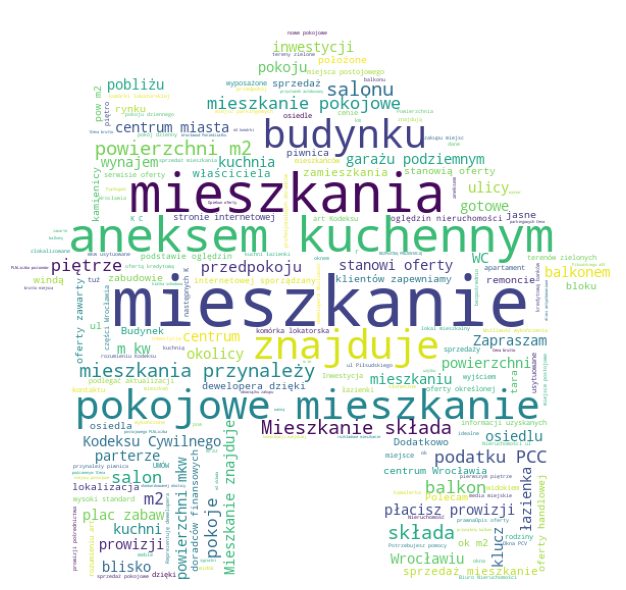

In [26]:
generate_wordcloud(words, mask, file_name='word_house')